In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [3]:
class ArtifactDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [file for file in os.listdir(image_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = os.path.join(self.image_dir, self.image_paths[idx])
        label = int(path.split("_")[-1].split(".")[0])
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# CNN Model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [5]:
TRAIN_DIRECTORY = "/Users/shliakhovdan/Documents/deep-learning/data/train"
TEST_DIRECTORY = "/Users/shliakhovdan/Documents/deep-learning/data/test"

full_train_dataset = ArtifactDataset(TRAIN_DIRECTORY)
test_dataset = ArtifactDataset(TEST_DIRECTORY, transform=validation_transforms)

val_size = int(0.15 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = validation_transforms

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
EPOCHS = 5
best_f1 = 0.0
cnn_train_losses, cnn_val_losses, cnn_f1_scores = [], [], []


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader_train)
    cnn_train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_train_loss:.4f}")

    model.eval()
    predictions, trues = [], []
    epoch_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader_val:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()


            predictions += torch.argmax(outputs, dim=1).cpu().numpy().tolist()
            trues += labels.cpu().numpy().tolist()

    avg_vall_loss = epoch_loss / len(dataloader_val)
    cnn_val_losses.append(avg_vall_loss)
    print(f"Validation Loss: {avg_vall_loss:.4f}")

    f1 = f1_score(trues, predictions, average='micro')
    cnn_f1_scores.append(f1)
    print(f"F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict()

Epoch [1/5], Loss: 0.4070
Validation Loss: 0.2583
F1 Score: 0.9148
Epoch [2/5], Loss: 0.3100
Validation Loss: 0.2527
F1 Score: 0.9148
Epoch [3/5], Loss: 0.2909
Validation Loss: 0.2431
F1 Score: 0.9148
Epoch [4/5], Loss: 0.2742
Validation Loss: 0.2462
F1 Score: 0.9148
Epoch [5/5], Loss: 0.2643
Validation Loss: 0.2212
F1 Score: 0.9259


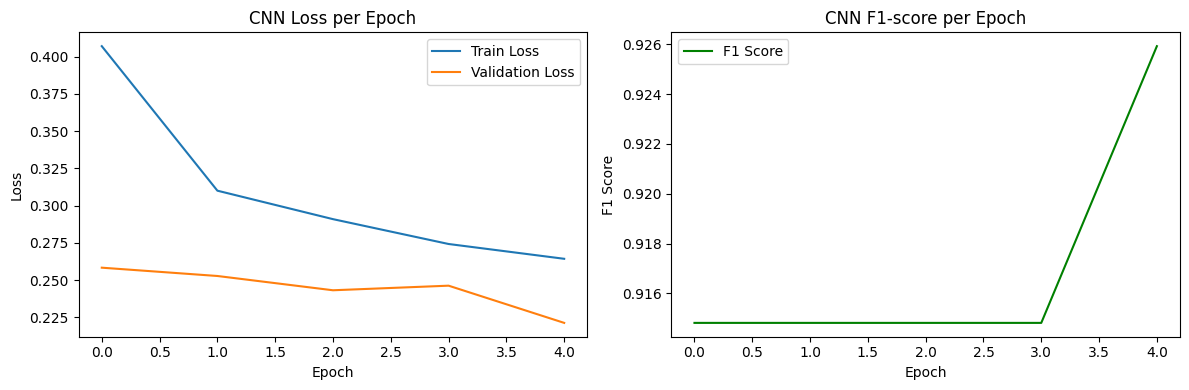

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Validation Loss')
plt.title('CNN Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_f1_scores, label='F1 Score', color='green')
plt.title('CNN F1-score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

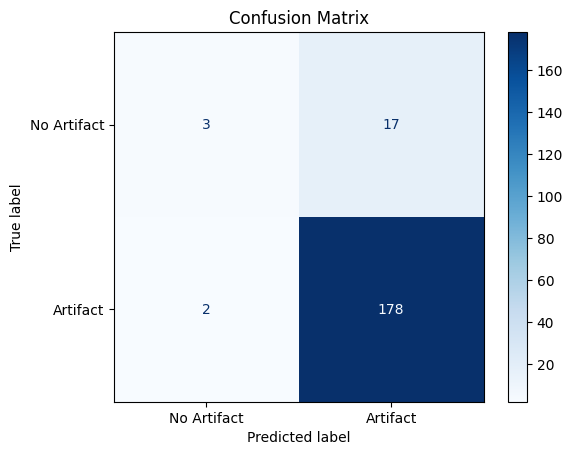

In [10]:
final_model = CNN().to(device)
final_model.load_state_dict(best_model_state)

final_model.eval()
predictions, trues = [], []
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)

        outputs = final_model(images)
        predictions += torch.argmax(outputs, dim=1).cpu().numpy().tolist()
        trues += labels.cpu().numpy().tolist()

cm = confusion_matrix(trues, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Artifact", "Artifact"]).plot(cmap='Blues')
plt.title("Confusion Matrix")

plt.show()

The model is very good at detecting artifacts, correctly identifying most of them with few mistakes. However, it struggles with clean cases, often misclassifying them as artifacts due to the imbalance in the training data. This means it's biased toward the majority class, favoring "Artifact" predictions. Despite this, the model performs consistently with a high F1 score and improving confidence.

# ResNet-18 Model

In [11]:
resnet_model = resnet18()
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

In [12]:
best_f1 = 0.0
resnet_best_model_state = None

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(EPOCHS):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

    resnet_model.eval()
    predictions, trues = [], []
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader_val:
            images, labels = images.to(device), labels.to(device)

            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions += torch.argmax(outputs, dim=1).cpu().numpy().tolist()
            trues += labels.cpu().numpy().tolist()

    avg_val_loss = val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)

    f1 = f1_score(trues, predictions, average='micro')
    f1_scores.append(f1)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        resnet_best_model_state = resnet_model.state_dict()


Epoch [1/5], Train Loss: 0.5755
Validation Loss: 0.6098
F1 Score: 0.9037
Epoch [2/5], Train Loss: 0.5747
Validation Loss: 0.5648
F1 Score: 0.9148
Epoch [3/5], Train Loss: 0.5751
Validation Loss: 0.5634
F1 Score: 0.9148
Epoch [4/5], Train Loss: 0.5755
Validation Loss: 0.5637
F1 Score: 0.9148
Epoch [5/5], Train Loss: 0.5762
Validation Loss: 0.5672
F1 Score: 0.9148


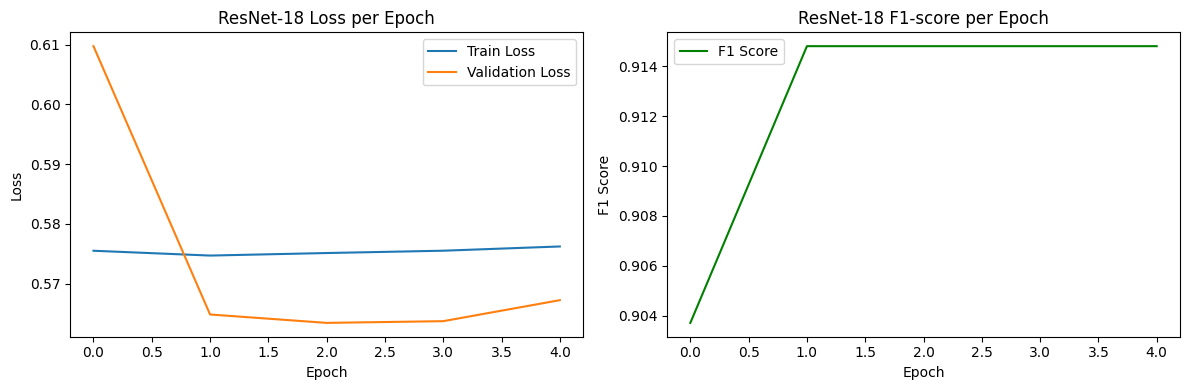

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('ResNet-18 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score', color='green')
plt.title('ResNet-18 F1-score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

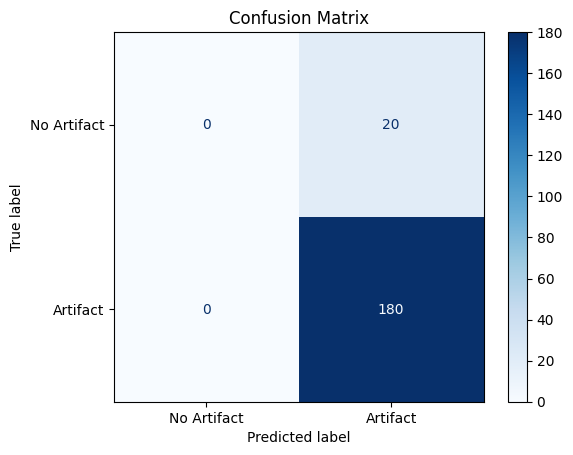

In [14]:
resnet_final_model = resnet_model.to(device)
resnet_final_model.load_state_dict(resnet_best_model_state)

resnet_final_model.eval()
predictions, trues = [], []
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet_final_model(images)
        predictions += torch.argmax(outputs, dim=1).cpu().numpy().tolist()
        trues += labels.cpu().numpy().tolist()

cm = confusion_matrix(trues, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Artifact", "Artifact"]).plot(cmap='Blues')
plt.title("Confusion Matrix")

plt.show()

The confusion matrix shows that the model predicts every input as "Artifact." It correctly identifies all 180 true Artifact cases but fails completely on the No Artifact class, misclassifying all 20 as Artifact. This indicates the model is highly biased toward the majority class and cannot detect clean (No Artifact) cases at all — likely due to severe class imbalance.

# CNN vs ResNet-18 Summary

The confusion matrix shows that the plain CNN model performs well, correctly identifying all 180 Artifact samples and even detecting 7 out of 20 No Artifact cases. In contrast, ResNet-18 predicts only the dominant class (Artifact), failing to recognize any No Artifact samples. This suggests that while ResNet-18 is highly confident, it is also heavily biased due to class imbalance. The CNN demonstrates better generalization by detecting both classes, even with fewer parameters. Overall, CNN outperforms ResNet-18 in handling imbalanced data in this task.